In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.font_manager as fm
import koreanize_matplotlib

# 폰트 경로 확인 및 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 설치된 폰트 경로
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 한글 깨짐 방지 - 마이너스 기호 처리
plt.rcParams['axes.unicode_minus'] = False

In [4]:
votes_df = pd.read_parquet("gs://final_project_enuyu/data/final_project/votes/accounts_userquestionrecord.parquet")
users_df = pd.read_parquet("gs://final_project_enuyu/data/final_project/votes/accounts_user.parquet")
school_df = pd.read_parquet("gs://final_project_enuyu/data/final_project/votes/accounts_group.parquet")

In [5]:
# 날짜 정제
votes_df["vote_date"] = pd.to_datetime(votes_df["created_at"]).dt.date

# 해당 기간(4/28 ~ 5/25)에 투표한 유저 ID
target_user_ids = votes_df[
    (votes_df["vote_date"] >= pd.to_datetime("2023-04-28").date()) &
    (votes_df["vote_date"] <= pd.to_datetime("2023-05-25").date())
]["user_id"].unique()

# school_id가 존재하는 group만 추출
school_df_valid = school_df[school_df["school_id"].notnull()].copy()

# school_id를 유저에게 붙이기 (users → school_df)
users_with_school = users_df.merge(
    school_df_valid[["id", "school_id"]],
    left_on="group_id", right_on="id", how="left"
).drop(columns="id_y").rename(columns={"id_x": "user_id"})

# 해당 유저 중에서 위 기간에 투표한 유저만 필터링
target_users = users_with_school[users_with_school["user_id"].isin(target_user_ids)]

# 투표한 유저가 소속된 학교 ID들 (유니크)
active_school_ids = target_users["school_id"].dropna().unique()
print(" 해당 기간에 투표 발생한 학교 수:", len(active_school_ids))

# 이 학교 ID에 속한 전체 유저 수
final_user_count = users_with_school[
    users_with_school["school_id"].isin(active_school_ids)
]["user_id"].nunique()

print(" 해당 학교에 소속된 유저 수:", final_user_count)

 해당 기간에 투표 발생한 학교 수: 10
 해당 학교에 소속된 유저 수: 5090


In [6]:
active_school_ids

array([ 271.,  369., 5491.,  352., 4516., 4426., 1478., 5520., 5372.,
       1719.])

In [7]:
# 해당 학교에 속한 유저 ID 목록
target_school_user_ids = users_with_school[
    users_with_school["school_id"].isin(active_school_ids)
]["user_id"].unique()

# 해당 유저 중에서 4/28 ~ 5/25 기간에 투표한 유저 수
voted_users_in_target_schools = votes_df[
    (votes_df["vote_date"] >= pd.to_datetime("2023-04-28").date()) &
    (votes_df["vote_date"] <= pd.to_datetime("2023-05-25").date()) &
    (votes_df["user_id"].isin(target_school_user_ids))
]["user_id"].nunique()

print(" 해당 10개 학교 유저 중 실제 투표한 유저 수:", voted_users_in_target_schools)

 해당 10개 학교 유저 중 실제 투표한 유저 수: 4703


In [8]:
# vote_date 파싱
votes_df["vote_date"] = pd.to_datetime(votes_df["created_at"]).dt.normalize()

# cohort_day (첫 투표일) 생성
cohort_df = votes_df.groupby("user_id")["vote_date"].min().reset_index(name="cohort_day")

# 대상 유저만 필터링 (4703명)
votes_filtered_df = votes_df[votes_df["user_id"].isin(target_user_ids)].copy()
votes_filtered_df = votes_filtered_df.merge(cohort_df, on="user_id", how="left")

# active_day 계산
votes_filtered_df["active_day"] = (votes_filtered_df["vote_date"] - votes_filtered_df["cohort_day"]).dt.days

# 기간 필터 (cohort_day 기준 4/29~5/25 사이)
votes_filtered_df = votes_filtered_df[
    (votes_filtered_df["cohort_day"] >= "2023-04-28") &
    (votes_filtered_df["cohort_day"] <= "2023-05-25") &
    (votes_filtered_df["active_day"] >= 0)
]

# cohort 크기 계산
cohort_size_df = votes_filtered_df.groupby("cohort_day")["user_id"].nunique().reset_index(name="cohort_size")

# active_day별 유지 유저 수
retained_df = votes_filtered_df.groupby(["cohort_day", "active_day"])["user_id"] \
    .nunique().reset_index(name="retained")

# 리텐션율 계산
ret_df = retained_df.merge(cohort_size_df, on="cohort_day")
ret_df["rate"] = ret_df["retained"] / ret_df["cohort_size"]

/tmp/ipykernel_4052563/3080609237.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot       = heat_28.applymap(lambda x: f"{x:.1%}"),


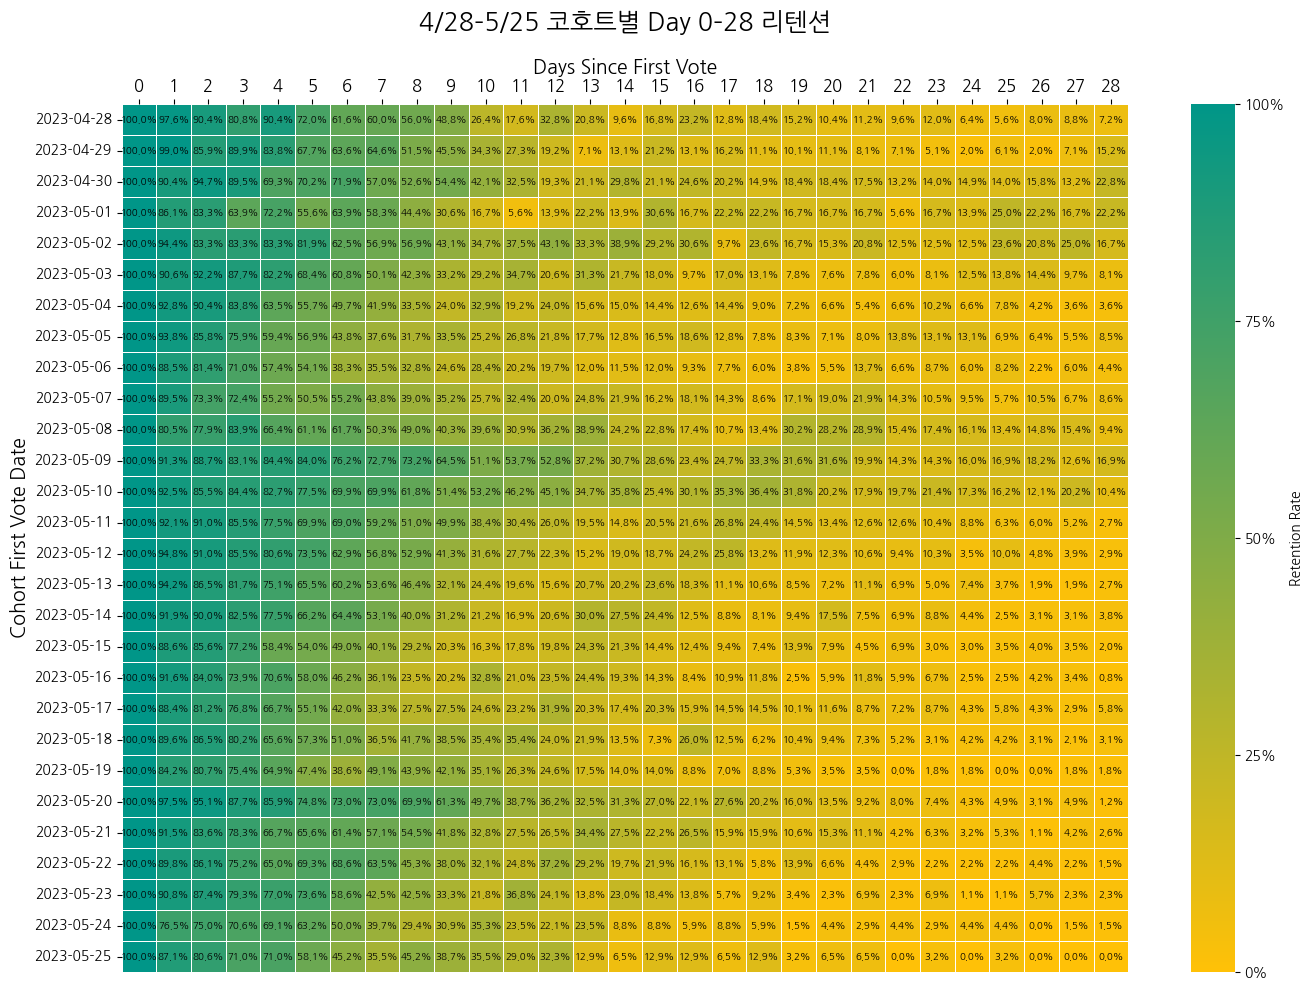

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib import ticker

# 1) 코호트-테이블: Day 0~28만 추출
heat_df  = ret_df.pivot(index="cohort_day", columns="active_day",
                        values="rate").fillna(0)
heat_28 = heat_df.loc[:, :28]          # ← 변수 이름만 heat_sub 로 통일

# 2) 컬러맵
custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    "team_palette", ["#ffc107", "#009688"], N=256
)

# 3) 히트맵
plt.figure(figsize=(14, 10))
ax = sns.heatmap(
    heat_28,
    cmap        = custom_cmap,
    annot       = heat_28.applymap(lambda x: f"{x:.1%}"),
    fmt         = "",
    annot_kws   = {"size": 7, "color": "black"},
    linewidths  = 0.5,
    linecolor   = "white",
    vmin        = 0, vmax=1,
    cbar_kws    = {
        "label": "Retention Rate",
        "format": ticker.PercentFormatter(xmax=1, decimals=0),
        "ticks": [0, 0.25, 0.5, 0.75, 1.0]
    }
)

# 4) 축 레이블 - 날짜는 ‘YYYY-MM-DD’만 남기고 시간 제거
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.xticks(rotation=0, fontsize=12)

date_labels = heat_sub.index.strftime('%Y-%m-%d')    # 시간 없이 날짜만
ax.set_yticklabels(date_labels, rotation=0, fontsize=10)

# 5) 제목 및 축제목
plt.title("4/28–5/25 코호트별 Day 0–28 리텐션", fontsize=18, pad=20)
plt.xlabel("Days Since First Vote",  fontsize=14)
plt.ylabel("Cohort First Vote Date", fontsize=14)

plt.tight_layout()
plt.show()


In [14]:
heat_28 = (heat_28 * 100).round(1)
display(heat_28)

active_day,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
cohort_day,,,,,,,,,,,,,,,,,,,,,
2023-04-28,100.0,97.6,90.4,80.8,90.4,72.0,61.6,60.0,56.0,48.8,...,15.2,10.4,11.2,9.6,12.0,6.4,5.6,8.0,8.8,7.2
2023-04-29,100.0,99.0,85.9,89.9,83.8,67.7,63.6,64.6,51.5,45.5,...,10.1,11.1,8.1,7.1,5.1,2.0,6.1,2.0,7.1,15.2
2023-04-30,100.0,90.4,94.7,89.5,69.3,70.2,71.9,57.0,52.6,54.4,...,18.4,18.4,17.5,13.2,14.0,14.9,14.0,15.8,13.2,22.8
2023-05-01,100.0,86.1,83.3,63.9,72.2,55.6,63.9,58.3,44.4,30.6,...,16.7,16.7,16.7,5.6,16.7,13.9,25.0,22.2,16.7,22.2
2023-05-02,100.0,94.4,83.3,83.3,83.3,81.9,62.5,56.9,56.9,43.1,...,16.7,15.3,20.8,12.5,12.5,12.5,23.6,20.8,25.0,16.7
2023-05-03,100.0,90.6,92.2,87.7,82.2,68.4,60.8,50.1,42.3,33.2,...,7.8,7.6,7.8,6.0,8.1,12.5,13.8,14.4,9.7,8.1
2023-05-04,100.0,92.8,90.4,83.8,63.5,55.7,49.7,41.9,33.5,24.0,...,7.2,6.6,5.4,6.6,10.2,6.6,7.8,4.2,3.6,3.6
2023-05-05,100.0,93.8,85.8,75.9,59.4,56.9,43.8,37.6,31.7,33.5,...,8.3,7.1,8.0,13.8,13.1,13.1,6.9,6.4,5.5,8.5
2023-05-06,100.0,88.5,81.4,71.0,57.4,54.1,38.3,35.5,32.8,24.6,...,3.8,5.5,13.7,6.6,8.7,6.0,8.2,2.2,6.0,4.4


In [15]:
cohort_size_df

,cohort_day,cohort_size
0,2023-04-28,125
1,2023-04-29,99
2,2023-04-30,114
3,2023-05-01,36
4,2023-05-02,72
5,2023-05-03,383
6,2023-05-04,167
7,2023-05-05,436
8,2023-05-06,183
9,2023-05-07,105


In [16]:
cohort_size_df["cohort_size"].sum()

4703

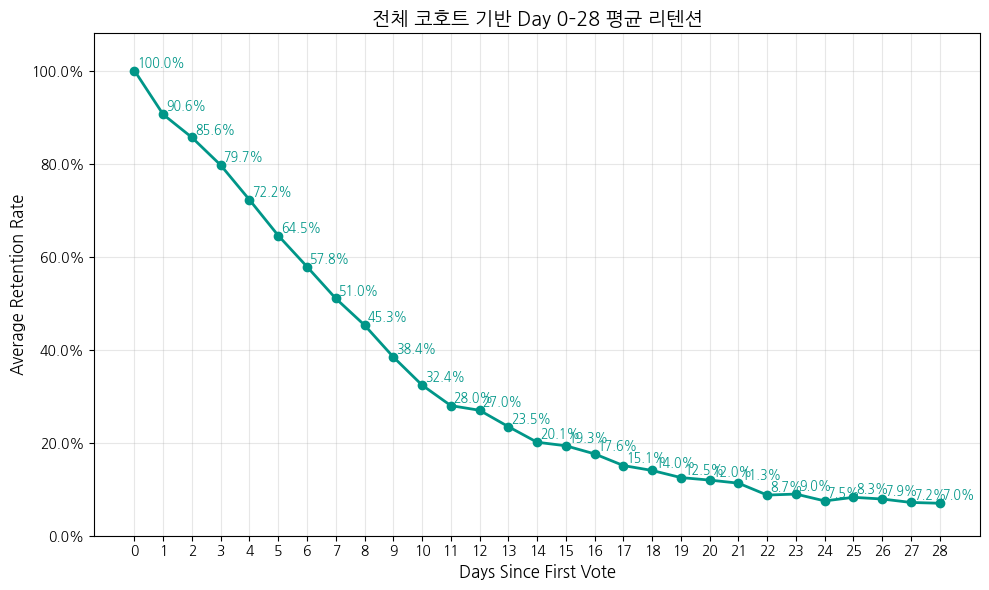

In [17]:
# 수치 추가 후 조절

from matplotlib import ticker

# 평균 리텐션 계산 (Day 0~28)
avg_retention = (
    ret_df[ret_df["active_day"] <= 28]
    .groupby("active_day")["rate"]
    .mean()
    .reset_index()
)

# 라인 그래프 
plt.figure(figsize=(10, 6))
plt.plot(
    avg_retention["active_day"],
    avg_retention["rate"],
    marker="o",
    color="#009688",  #
    linewidth=2,
    label="평균 리텐션율"
)

# 각 점 위에 수치 표시
# 수치 표시를 좀 더 보기 좋게 띄워서 추가
for x, y in zip(avg_retention["active_day"], avg_retention["rate"]):
    plt.text(x + 0.1, y + 0.03, f"{y:.1%}", ha="left", va="top", fontsize=9, color="#009688")



# 레이블/그리드/포맷 설정
plt.xticks(range(0, 29))
plt.xlabel("Days Since First Vote", fontsize=12)
plt.ylabel("Average Retention Rate", fontsize=12)
plt.title("전체 코호트 기반 Day 0–28 평균 리텐션", fontsize=14)
plt.grid(alpha=0.3)
plt.ylim(0, 1.08)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
plt.tight_layout()
plt.show()

In [18]:
avg_retention

,active_day,rate
0,0,1.000000
1,1,0.905610
2,2,0.856124
3,3,0.796635
4,4,0.722113
5,5,0.645333
6,6,0.578382
7,7,0.510041
8,8,0.452761
9,9,0.384311


## 마스터 테이블

In [20]:
# 날짜 파싱
votes_df["vote_date"] = pd.to_datetime(votes_df["created_at"]).dt.date

# 기간 필터링: 4월 28일 ~ 5월 25일
votes_filtered_df = votes_df[
    (votes_df["vote_date"] >= pd.to_datetime("2023-04-28").date()) &
    (votes_df["vote_date"] <= pd.to_datetime("2023-05-25").date())
].copy()

In [21]:
# school_id가 존재하는 group만 필터링
school_df_valid = school_df[school_df["school_id"].notnull()].copy()

# 유저와 school 정보 연결
users_with_school = users_df.merge(
    school_df_valid[["id", "school_id"]],
    left_on="group_id", right_on="id", how="left"
).drop(columns="id_y").rename(columns={"id_x": "user_id"})

# 해당 기간에 투표한 유저 ID
target_user_ids = votes_filtered_df["user_id"].unique()

# 이 유저들 중 소속 학교 ID들 추출
target_users = users_with_school[users_with_school["user_id"].isin(target_user_ids)]
active_school_ids = target_users["school_id"].dropna().unique()

In [22]:
# 해당 10개 학교에 속한 유저만 추출
target_school_user_ids = users_with_school[
    users_with_school["school_id"].isin(active_school_ids)
]["user_id"].unique()

# 최종 유저로 vote 데이터 다시 필터링
votes_filtered_df = votes_filtered_df[
    votes_filtered_df["user_id"].isin(target_school_user_ids)
].copy()

In [23]:
# 유저별 행동 요약 집계
master_df = votes_filtered_df.groupby("user_id").agg(
    total_votes=("question_piece_id", "count"),
    unique_days=("vote_date", "nunique"),
    first_vote=("vote_date", "min"),
    last_vote=("vote_date", "max")
).reset_index()

# 활동 기간 추가 (일 단위)
master_df["active_days"] = (pd.to_datetime(master_df["last_vote"]) - pd.to_datetime(master_df["first_vote"])).dt.days

In [24]:
master_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days
0,838023,22,5,2023-04-29,2023-05-04,5
1,838466,127,6,2023-05-02,2023-05-07,5
2,838642,10,2,2023-04-28,2023-04-29,1
3,839357,205,8,2023-04-29,2023-05-07,8
4,840293,170,7,2023-05-03,2023-05-15,12
...,...,...,...,...,...,...
4698,1510561,9,1,2023-05-25,2023-05-25,0
4699,1511957,8,1,2023-05-25,2023-05-25,0
4700,1512422,22,1,2023-05-25,2023-05-25,0
4701,1512542,7,1,2023-05-25,2023-05-25,0


In [25]:
# cohort_day 컬럼 생성
master_df["cohort_day"] = pd.to_datetime(master_df["first_vote"])

In [26]:
master_df["cohort_day"]

0      2023-04-29
1      2023-05-02
2      2023-04-28
3      2023-04-29
4      2023-05-03
          ...    
4698   2023-05-25
4699   2023-05-25
4700   2023-05-25
4701   2023-05-25
4702   2023-05-25
Name: cohort_day, Length: 4703, dtype: datetime64[ns]

In [27]:
#  Day 8 리텐션 정보만 추출
day8_ret_df = ret_df[ret_df["active_day"] == 8][["cohort_day", "rate"]].copy()
day8_ret_df.rename(columns={"rate": "retention_day8"}, inplace=True)

In [28]:
#  cohort_day 기준으로 리텐션 정보 병합
master_df = master_df.merge(day8_ret_df, on="cohort_day", how="left")

In [29]:
master_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.515152
1,838466,127,6,2023-05-02,2023-05-07,5,2023-05-02,0.569444
2,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000
3,839357,205,8,2023-04-29,2023-05-07,8,2023-04-29,0.515152
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.422977
...,...,...,...,...,...,...,...,...
4698,1510561,9,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613
4699,1511957,8,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613
4700,1512422,22,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613
4701,1512542,7,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613


In [30]:
# 리텐션 그룹 컬럼 생성
master_df["ret_group"] = master_df["retention_day8"].apply(
    lambda x: "50 이상" if x >= 0.5 else "50 미만"
)

In [31]:
master_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,ret_group
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.515152,50 이상
1,838466,127,6,2023-05-02,2023-05-07,5,2023-05-02,0.569444,50 이상
2,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000,50 이상
3,839357,205,8,2023-04-29,2023-05-07,8,2023-04-29,0.515152,50 이상
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.422977,50 미만
...,...,...,...,...,...,...,...,...,...
4698,1510561,9,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만
4699,1511957,8,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만
4700,1512422,22,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만
4701,1512542,7,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만


In [32]:
# 리텐션 그룹 별로 분리된 컬럼 생성
master_df["ret_group_over"] = master_df["ret_group"].apply(
    lambda x: "50 이상" if x == "50 이상" else None
)

master_df["ret_group_under"] = master_df["ret_group"].apply(
    lambda x: "50 미만" if x == "50 미만" else None
)

In [33]:
master_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,ret_group,ret_group_over,ret_group_under
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.515152,50 이상,50 이상,None
1,838466,127,6,2023-05-02,2023-05-07,5,2023-05-02,0.569444,50 이상,50 이상,None
2,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000,50 이상,50 이상,None
3,839357,205,8,2023-04-29,2023-05-07,8,2023-04-29,0.515152,50 이상,50 이상,None
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.422977,50 미만,None,50 미만
...,...,...,...,...,...,...,...,...,...,...,...
4698,1510561,9,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,None,50 미만
4699,1511957,8,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,None,50 미만
4700,1512422,22,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,None,50 미만
4701,1512542,7,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,None,50 미만


In [34]:
master_df["ret_group_over"].count()

1841

In [35]:
master_df["ret_group_under"].count()

2862

In [36]:
# 이미 확보된 기준 유저 목록: target_user_ids (4703명)
# user_meta_df 생성 (기존 방식)
user_meta_df = users_df[["id", "gender", "group_id"]].rename(columns={"id": "user_id"})
school_info_df = school_df.rename(columns={"id": "group_id"})[["group_id", "school_id", "grade"]]
user_meta_df = user_meta_df.merge(school_info_df, on="group_id", how="left")

# 필터링: 리텐션 대상 유저만 남기기
user_meta_df = user_meta_df[user_meta_df["user_id"].isin(target_user_ids)].copy()

In [37]:
user_meta_df

,user_id,gender,group_id,school_id,grade
396,838023,F,233.0,271.0,1.0
633,838466,F,321.0,369.0,2.0
756,838642,F,356.0,271.0,2.0
1252,839357,M,519.0,271.0,1.0
1889,840293,F,838.0,369.0,1.0
...,...,...,...,...,...
609083,1510561,M,73885.0,4426.0,2.0
610323,1511957,F,29558.0,5520.0,2.0
610738,1512422,F,72313.0,4426.0,2.0
610834,1512542,F,72313.0,4426.0,2.0


In [38]:
master_df = master_df.merge(user_meta_df, on="user_id", how="left")

In [39]:
master_df

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,ret_group,ret_group_over,ret_group_under,gender,group_id,school_id,grade
0,838023,22,5,2023-04-29,2023-05-04,5,2023-04-29,0.515152,50 이상,50 이상,None,F,233.0,271.0,1.0
1,838466,127,6,2023-05-02,2023-05-07,5,2023-05-02,0.569444,50 이상,50 이상,None,F,321.0,369.0,2.0
2,838642,10,2,2023-04-28,2023-04-29,1,2023-04-28,0.560000,50 이상,50 이상,None,F,356.0,271.0,2.0
3,839357,205,8,2023-04-29,2023-05-07,8,2023-04-29,0.515152,50 이상,50 이상,None,M,519.0,271.0,1.0
4,840293,170,7,2023-05-03,2023-05-15,12,2023-05-03,0.422977,50 미만,None,50 미만,F,838.0,369.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4698,1510561,9,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,None,50 미만,M,73885.0,4426.0,2.0
4699,1511957,8,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,None,50 미만,F,29558.0,5520.0,2.0
4700,1512422,22,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,None,50 미만,F,72313.0,4426.0,2.0
4701,1512542,7,1,2023-05-25,2023-05-25,0,2023-05-25,0.451613,50 미만,None,50 미만,F,72313.0,4426.0,2.0


In [40]:
master_df.to_csv("최종 마스터 테이블(8일차)v1.csv", index=False)

In [41]:
master_df["ret_group_over"].count()

1841

In [42]:
master_df["ret_group_under"].count()

2862

In [43]:
# pivot 테이블 생성 (cohort_day x active_day)
ret_pivot = ret_df.pivot_table(
    index="cohort_day",     # 코호트 기준 (첫 투표일)
    columns="active_day",   # Day 0~25
    values="rate",          # 리텐션율
    fill_value=0            # 결측치는 0으로 처리
)

# Day 0~28만 필터링 (열 기준)
ret_pivot = ret_pivot.loc[:, 0:28]

#  보기 좋게 % 형식으로 (선택 사항)
ret_pivot_percent = (ret_pivot * 100).round(1)

# 결과 출력
display(ret_pivot_percent)

active_day,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
cohort_day,,,,,,,,,,,,,,,,,,,,,
2023-04-28,100.0,97.6,90.4,80.8,90.4,72.0,61.6,60.0,56.0,48.8,...,15.2,10.4,11.2,9.6,12.0,6.4,5.6,8.0,8.8,7.2
2023-04-29,100.0,99.0,85.9,89.9,83.8,67.7,63.6,64.6,51.5,45.5,...,10.1,11.1,8.1,7.1,5.1,2.0,6.1,2.0,7.1,15.2
2023-04-30,100.0,90.4,94.7,89.5,69.3,70.2,71.9,57.0,52.6,54.4,...,18.4,18.4,17.5,13.2,14.0,14.9,14.0,15.8,13.2,22.8
2023-05-01,100.0,86.1,83.3,63.9,72.2,55.6,63.9,58.3,44.4,30.6,...,16.7,16.7,16.7,5.6,16.7,13.9,25.0,22.2,16.7,22.2
2023-05-02,100.0,94.4,83.3,83.3,83.3,81.9,62.5,56.9,56.9,43.1,...,16.7,15.3,20.8,12.5,12.5,12.5,23.6,20.8,25.0,16.7
2023-05-03,100.0,90.6,92.2,87.7,82.2,68.4,60.8,50.1,42.3,33.2,...,7.8,7.6,7.8,6.0,8.1,12.5,13.8,14.4,9.7,8.1
2023-05-04,100.0,92.8,90.4,83.8,63.5,55.7,49.7,41.9,33.5,24.0,...,7.2,6.6,5.4,6.6,10.2,6.6,7.8,4.2,3.6,3.6
2023-05-05,100.0,93.8,85.8,75.9,59.4,56.9,43.8,37.6,31.7,33.5,...,8.3,7.1,8.0,13.8,13.1,13.1,6.9,6.4,5.5,8.5
2023-05-06,100.0,88.5,81.4,71.0,57.4,54.1,38.3,35.5,32.8,24.6,...,3.8,5.5,13.7,6.6,8.7,6.0,8.2,2.2,6.0,4.4
